In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
clean_data_filename = '/content/drive/MyDrive/hw4_files/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/hw4_files/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/hw4_files/model/sunglasses_bd_net.h5'

In [4]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('clean classification accuracy:', clean_accuracy)

    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('attack success rate:', asr)

if __name__ == '__main__':
    main()

361/361 [==============================] - 4s 10ms/step
clean classification accuracy: 42.25339915129471
361/361 [==============================] - 3s 9ms/step
attack success rate: 99.9047371611674


In [5]:
model = keras.models.load_model(model_filename)


In [6]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [7]:

clean_x, clean_y = data_loader(clean_data_filename)

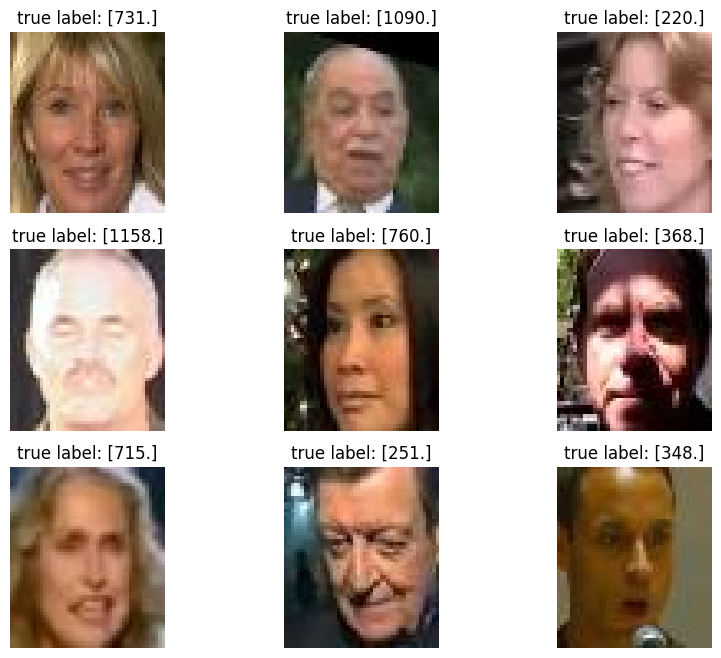

In [8]:
visualization_figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    index = np.random.randint(clean_x.shape[0], size=1)
    img, label = (clean_x[index], clean_y[index])
    visualization_figure.add_subplot(rows, cols, i)
    plt.title("true label: {}".format(label))
    plt.axis("off")
    plt.imshow(img[0] / 255)

plt.show()


In [9]:
poisoned_x_data, poisoned_y_data = data_loader(poisoned_data_filename)


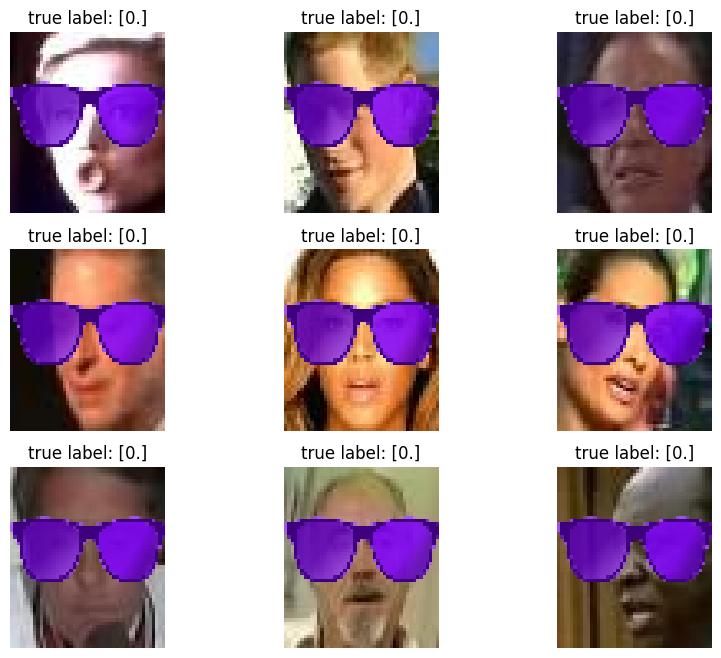

In [10]:
poisoned_data_figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    index = np.random.randint(poisoned_x_data.shape[0], size=1)
    img, label = (poisoned_x_data[index], poisoned_y_data[index])
    poisoned_data_figure.add_subplot(rows, cols, i)
    plt.title("true label: {}".format(label))
    plt.axis("off")
    plt.imshow(img[0] / 255)

plt.show()


In [11]:

keras.backend.clear_session()


In [12]:
# Getting the data
clean_test_data, clean_test_labels = data_loader(clean_data_filename)
poisoned_test_data, poisoned_test_labels = data_loader(poisoned_data_filename)


In [13]:
clean_data_accuracy = 98.64899974019225
pruned_model = keras.models.clone_model(model)
pruned_model.set_weights(model.get_weights())
prune_index = []
clean_accuracies = []
attack_success_rates = []
saved_model_flags = np.zeros(3, dtype=bool)

# Getting the activation from the last pooling layer
layer_output = pruned_model.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=pruned_model.input, outputs=layer_output)
intermediate_predictions = intermediate_model.predict(clean_test_data)
temp = np.mean(intermediate_predictions, axis=(0, 1, 2))
seq = np.argsort(temp)
weight_0 = pruned_model.layers[5].get_weights()[0]
bias_0 = pruned_model.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    pruned_model.layers[5].set_weights([weight_0, bias_0])

    clean_label = np.argmax(pruned_model.predict(clean_test_data), axis=1)
    clean_accuracy = np.mean(np.equal(clean_label, clean_test_labels)) * 100

    if (clean_data_accuracy - clean_accuracy >= 2 and not saved_model_flags[0]):
        print("The accuracy drops at least 2%, saved the model")
        pruned_model.save('model_X=2.h5')
        saved_model_flags[0] = 1
    if (clean_data_accuracy - clean_accuracy >= 4 and not saved_model_flags[1]):
        print("The accuracy drops at least 4%, saved the model")
        pruned_model.save('model_X=4.h5')
        saved_model_flags[1] = 1
    if (clean_data_accuracy - clean_accuracy >= 10 and not saved_model_flags[2]):
        print("The accuracy drops at least 10%, saved the model")
        pruned_model.save('model_X=10.h5')
        saved_model_flags[2] = 1

    clean_accuracies.append(clean_accuracy)

    poisoned_label = np.argmax(pruned_model.predict(poisoned_test_data), axis=1)
    attack_success_rate = np.mean(np.equal(poisoned_label, poisoned_test_labels)) * 100
    attack_success_rates.append(attack_success_rate)

    print()
    print("clean accuracy= ", clean_accuracy)
    print("pruned channel index=", channel_index)
    print("attack success rate= ", attack_success_rate)

    keras.backend.clear_session()


361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The accuracy drops at least 2%, saved the model


The accuracy drops at least 4%, saved the model


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:10<10:08, 10.31s/it]


clean accuracy=  42.25339915129471
pruned channel index= 32
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


  3%|▎         | 2/60 [00:21<10:17, 10.64s/it]


clean accuracy=  42.25339915129471
pruned channel index= 44
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


  5%|▌         | 3/60 [00:31<10:02, 10.56s/it]


clean accuracy=  42.25339915129471
pruned channel index= 49
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:40<09:21, 10.03s/it]


clean accuracy=  42.2620594093704
pruned channel index= 37
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 11ms/step

clean accuracy=  42.2620594093704
pruned channel index= 36
attack success rate=  99.9047371611674


  8%|▊         | 5/60 [00:51<09:20, 10.19s/it]

361/361 [==============================] - 4s 11ms/step


 10%|█         | 6/60 [01:01<09:18, 10.34s/it]


clean accuracy=  42.2620594093704
pruned channel index= 31
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:11<08:49,  9.98s/it]


clean accuracy=  42.25339915129471
pruned channel index= 50
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:22<09:02, 10.44s/it]


clean accuracy=  42.24473889321902
pruned channel index= 48
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step

clean accuracy=  42.227418377067636
pruned channel index= 33
attack success rate=  99.9047371611674


 15%|█▌        | 9/60 [01:31<08:35, 10.10s/it]

361/361 [==============================] - 3s 9ms/step


 17%|█▋        | 10/60 [01:40<08:07,  9.75s/it]


clean accuracy=  42.184117086689184
pruned channel index= 14
attack success rate=  99.9047371611674
361/361 [==============================] - 3s 10ms/step


 18%|█▊        | 11/60 [01:51<08:15, 10.12s/it]


clean accuracy=  42.07153373170521
pruned channel index= 35
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


 20%|██        | 12/60 [02:01<07:57,  9.94s/it]


clean accuracy=  42.097514505932274
pruned channel index= 34
attack success rate=  99.9047371611674
361/361 [==============================] - 3s 10ms/step


 22%|██▏       | 13/60 [02:12<07:55, 10.13s/it]


clean accuracy=  41.88100805404001
pruned channel index= 1
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step

clean accuracy=  41.65584134407205
pruned channel index= 2
attack success rate=  99.9047371611674


 23%|██▎       | 14/60 [02:21<07:42, 10.06s/it]

361/361 [==============================] - 4s 10ms/step


 25%|██▌       | 15/60 [02:31<07:22,  9.83s/it]


clean accuracy=  41.48263618255824
pruned channel index= 42
attack success rate=  99.9047371611674
361/361 [==============================] - 4s 10ms/step


 27%|██▋       | 16/60 [02:42<07:28, 10.19s/it]


clean accuracy=  41.44799515025548
pruned channel index= 12
attack success rate=  99.9047371611674
361/361 [==============================] - 3s 9ms/step


 28%|██▊       | 17/60 [02:51<07:12, 10.06s/it]


clean accuracy=  41.188187407984756
pruned channel index= 24
attack success rate=  99.89607690309171
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [03:02<07:12, 10.30s/it]


clean accuracy=  40.61661037498918
pruned channel index= 47
attack success rate=  99.88741664501603
361/361 [==============================] - 4s 10ms/step


 32%|███▏      | 19/60 [03:12<06:53, 10.08s/it]


clean accuracy=  39.36953321208972
pruned channel index= 3
attack success rate=  99.89607690309171
361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:22<06:40, 10.02s/it]


clean accuracy=  38.62475101758032
pruned channel index= 29
attack success rate=  99.89607690309171
361/361 [==============================] - 4s 10ms/step


 35%|███▌      | 21/60 [03:31<06:22,  9.80s/it]


clean accuracy=  38.1830778557201
pruned channel index= 58
attack success rate=  99.88741664501603
361/361 [==============================] - 4s 10ms/step


 37%|███▋      | 22/60 [03:42<06:26, 10.16s/it]


clean accuracy=  37.550879016194685
pruned channel index= 0
attack success rate=  99.87875638694032
361/361 [==============================] - 3s 10ms/step


 38%|███▊      | 23/60 [03:52<06:10, 10.01s/it]


clean accuracy=  36.944660950896335
pruned channel index= 8
attack success rate=  99.89607690309171
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [04:02<06:07, 10.22s/it]


clean accuracy=  35.368493981120636
pruned channel index= 11
attack success rate=  99.85277561271326
361/361 [==============================] - 4s 11ms/step


 42%|████▏     | 25/60 [04:12<05:51, 10.03s/it]


clean accuracy=  34.242660431280854
pruned channel index= 23
attack success rate=  99.84411535463757
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:23<05:46, 10.19s/it]


clean accuracy=  33.203429462197974
pruned channel index= 25
attack success rate=  99.83545509656187
361/361 [==============================] - 4s 11ms/step

clean accuracy=  33.082185849138305
pruned channel index= 52
attack success rate=  99.77483329003203


 45%|████▌     | 27/60 [04:33<05:33, 10.12s/it]

361/361 [==============================] - 4s 11ms/step


 47%|████▋     | 28/60 [04:42<05:21, 10.05s/it]


clean accuracy=  32.57123062267255
pruned channel index= 28
attack success rate=  99.73153199965358
361/361 [==============================] - 4s 10ms/step


 48%|████▊     | 29/60 [04:53<05:12, 10.07s/it]


clean accuracy=  32.38070494500736
pruned channel index= 57
attack success rate=  99.67957045119945
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [05:02<05:00, 10.01s/it]


clean accuracy=  30.96042262059409
pruned channel index= 15
attack success rate=  99.68823070927513
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [05:13<04:56, 10.23s/it]


clean accuracy=  30.64865332986923
pruned channel index= 16
attack success rate=  99.70555122542652
361/361 [==============================] - 3s 9ms/step


 53%|█████▎    | 32/60 [05:23<04:42, 10.08s/it]


clean accuracy=  28.630813198233305
pruned channel index= 43
attack success rate=  99.69689096735083
361/361 [==============================] - 4s 10ms/step

clean accuracy=  25.582402355590194
pruned channel index= 41
attack success rate=  99.5323460639127


 55%|█████▌    | 33/60 [05:32<04:27,  9.89s/it]

361/361 [==============================] - 4s 12ms/step

clean accuracy=  20.793279639733264
pruned channel index= 55
attack success rate=  99.33316012817181


 57%|█████▋    | 34/60 [05:42<04:17,  9.91s/it]

361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:52<04:07,  9.88s/it]


clean accuracy=  18.818740798475794
pruned channel index= 40
attack success rate=  99.28119857971768
361/361 [==============================] - 4s 10ms/step


 60%|██████    | 36/60 [06:01<03:53,  9.71s/it]


clean accuracy=  19.624144799515026
pruned channel index= 9
attack success rate=  99.37646141855028
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:12<03:49,  9.98s/it]


clean accuracy=  17.329176409457002
pruned channel index= 19
attack success rate=  99.36780116047458
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:24<03:55, 10.71s/it]


clean accuracy=  15.285355503594007
pruned channel index= 56
attack success rate=  99.19459599896076
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:34<03:35, 10.28s/it]


clean accuracy=  14.523252792933231
pruned channel index= 10
attack success rate=  98.9001472243873
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:44<03:27, 10.36s/it]


clean accuracy=  13.839092404953668
pruned channel index= 18
attack success rate=  98.91746774053867
361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [06:54<03:11, 10.08s/it]


clean accuracy=  12.271585693253659
pruned channel index= 46
attack success rate=  98.64033948211657
361/361 [==============================] - 3s 10ms/step


 70%|███████   | 42/60 [07:03<02:56,  9.81s/it]


clean accuracy=  10.011258335498399
pruned channel index= 6
attack success rate=  98.36321122369446
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:12<02:44,  9.68s/it]


clean accuracy=  8.287866978435957
pruned channel index= 30
attack success rate=  95.5572876071707
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:22<02:34,  9.63s/it]


clean accuracy=  6.720360266735949
pruned channel index= 45
attack success rate=  92.94188966831211
361/361 [==============================] - 3s 10ms/step

clean accuracy=  4.945007361219364
pruned channel index= 4
attack success rate=  

 75%|███████▌  | 45/60 [07:31<02:22,  9.50s/it]

93.12375508790161
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:41<02:14,  9.58s/it]


clean accuracy=  4.174244392482896
pruned channel index= 53
attack success rate=  92.78600502294968
361/361 [==============================] - 4s 10ms/step

clean accuracy=  4.1136225859530615
pruned channel index= 20
attack success rate=  86.44669611154411


 78%|███████▊  | 47/60 [07:51<02:06,  9.70s/it]

361/361 [==============================] - 4s 10ms/step

clean accuracy=  3.524725036806097
pruned channel index= 17
attack success rate=  87.81501688750325


 80%|████████  | 48/60 [08:01<01:56,  9.75s/it]

361/361 [==============================] - 4s 11ms/step

clean accuracy=  3.0830518749458733
pruned channel index= 38
attack success rate=  80.37585520048496


 82%|████████▏ | 49/60 [08:12<01:53, 10.31s/it]

361/361 [==============================] - 4s 11ms/step


 83%|████████▎ | 50/60 [08:24<01:48, 10.84s/it]


clean accuracy=  3.3168788429895213
pruned channel index= 27
attack success rate=  88.85424785658613
361/361 [==============================] - 4s 11ms/step

clean accuracy=  2.892526197280679
pruned channel index= 26
attack success rate=  95.72183251060882


 85%|████████▌ | 51/60 [08:35<01:36, 10.72s/it]

361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:45<01:25, 10.66s/it]


clean accuracy=  2.407551745042002
pruned channel index= 59
attack success rate=  96.44929418896683
361/361 [==============================] - 4s 11ms/step

clean accuracy=  1.4895643890187926
pruned channel index= 7
attack success rate=  97.4019225772928


 88%|████████▊ | 53/60 [08:56<01:15, 10.75s/it]

361/361 [==============================] - 4s 11ms/step

clean accuracy=  0.883346323720447
pruned channel index= 39
attack success rate=  98.9780895470685


 90%|█████████ | 54/60 [09:07<01:03, 10.64s/it]

361/361 [==============================] - 4s 11ms/step

clean accuracy=  0.3117692907248636
pruned channel index= 22
attack success rate=  99.93937819347016


 92%|█████████▏| 55/60 [09:17<00:53, 10.66s/it]

361/361 [==============================] - 4s 10ms/step


 93%|█████████▎| 56/60 [09:29<00:43, 10.84s/it]


clean accuracy=  0.3117692907248636
pruned channel index= 54
attack success rate=  99.22057677318784
361/361 [==============================] - 4s 11ms/step

clean accuracy=  0.3550705811033169
pruned channel index= 21
attack success rate=  95.93833896250108


 95%|█████████▌| 57/60 [09:40<00:32, 10.91s/it]

361/361 [==============================] - 4s 11ms/step

clean accuracy=  0.20784619381657576
pruned channel index= 5
attack success rate=  99.92205767731879


 97%|█████████▋| 58/60 [09:51<00:21, 10.94s/it]

361/361 [==============================] - 4s 11ms/step


 98%|█████████▊| 59/60 [10:03<00:11, 11.39s/it]


clean accuracy=  0.08660258075690655
pruned channel index= 51
attack success rate=  100.0
361/361 [==============================] - 4s 12ms/step


100%|██████████| 60/60 [10:15<00:00, 10.25s/it]


clean accuracy=  0.0779423226812159
pruned channel index= 13
attack success rate=  0.0


In [14]:
print("attack success rates=", attack_success_rates)
print("clean accuracies=", clean_accuracies)



attack success rates= [99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.9047371611674, 99.89607690309171, 99.88741664501603, 99.89607690309171, 99.89607690309171, 99.88741664501603, 99.87875638694032, 99.89607690309171, 99.85277561271326, 99.84411535463757, 99.83545509656187, 99.77483329003203, 99.73153199965358, 99.67957045119945, 99.68823070927513, 99.70555122542652, 99.69689096735083, 99.5323460639127, 99.33316012817181, 99.28119857971768, 99.37646141855028, 99.36780116047458, 99.19459599896076, 98.9001472243873, 98.91746774053867, 98.64033948211657, 98.36321122369446, 95.5572876071707, 92.94188966831211, 93.12375508790161, 92.78600502294968, 86.44669611154411, 87.81501688750325, 80.37585520048496, 88.85424785658613, 95.72183251060882, 96.44929418896683, 97.40192

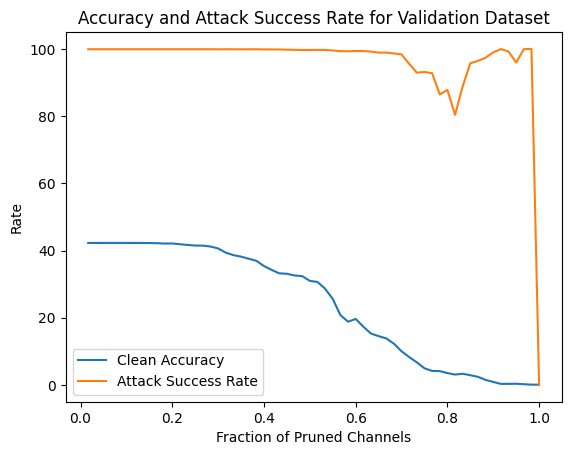

In [15]:
x_axis = np.arange(1, 61) / 60
plt.plot(x_axis, clean_accuracies, label='Clean Accuracy')
plt.plot(x_axis, attack_success_rates, label='Attack Success Rate')
plt.legend()
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Accuracy and Attack Success Rate for Validation Dataset")
plt.show()


In [16]:
index = np.where(np.array(clean_accuracies) <= (clean_data_accuracy - 30))[0]

if index.size > 0:
    print("attack success rate when the accuracy drop is >=30%: ", attack_success_rates[index[0]])
else:
    print("no index found where the clean accuracy drops is >= 30%.")


attack success rate when the accuracy drop is >=30%:  99.9047371611674


In [17]:
class G:
    def __init__(self, B, B_prime):
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        y = np.argmax(self.B.predict(data), axis=1)
        y_prime = np.argmax(self.B_prime.predict(data), axis=1)

        pred = np.zeros(data.shape[0], dtype=np.int64)

        for i in range(data.shape[0]):
            if y[i] == y_prime[i]:
                pred[i] = y[i]
            else:
                pred[i] = 1283

        return pred

In [18]:
test_data_filename = '/content/drive/MyDrive/hw4_files/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/hw4_files/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [19]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [20]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)


In [21]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [22]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

In [23]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)


bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model - attack success rate:', asr_2)



cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model -the clean test data classification accuracy:', clean_test_4_accuracy)


bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model - attack success rate:', asr_4)




cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model- the clean test data classification accuracy:', clean_test_10_accuracy)


bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model-attack success rate:', asr_10)


401/401 [==============================] - 5s 11ms/step
2% drops model, the clean test data Classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 11ms/step
2% drops model - attack success rate: 99.92985190958692
401/401 [==============================] - 4s 11ms/step
4% drops model -the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 5s 12ms/step
4% drops model - attack success rate: 99.92985190958692
401/401 [==============================] - 5s 11ms/step
10% drops model- the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 5s 12ms/step
10% drops model-attack success rate: 99.92985190958692


In [24]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]

data = {
    "test_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}

df = pd.DataFrame(data)
df.set_index('model', inplace=True)

print(df)

               test_acc  attack_rate
model                               
repaired_2%   42.361652    99.929852
repaired_4%   42.361652    99.929852
repaired_10%  42.361652    99.929852


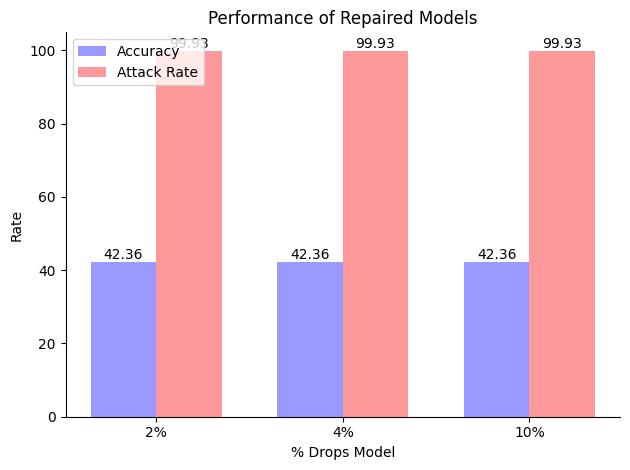

In [25]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% Drops Model')
plt.ylabel('Rate')
plt.xticks(range(len(test_acc)), ('2%', '4%', '10%'))

bar1 = plt.bar(np.arange(len(test_acc)) - bar_width / 2, test_acc, bar_width, align='center', alpha=opacity, color='b', label='Accuracy')
bar2 = plt.bar(np.arange(len(attack_rate)) + bar_width / 2, attack_rate, bar_width, align='center', alpha=opacity, color='r', label='Attack Rate')

for bars in [bar1, bar2]:
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(loc='upper left')
plt.title('Performance of Repaired Models')
sns.despine()
plt.tight_layout()
plt.show()

In [26]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(G_cl_test_2_label_p, y_test_data)) * 100
print('Combined 2% drops model- the clean test data classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(G_bd_test_2_label_p, y_test_poisnoed_data)) * 100
print('Combined 2% drops model -attack success rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(G_cl_test_4_label_p, y_test_data)) * 100
print('Combined 4% drops model - the clean test data classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(G_bd_test_4_label_p, y_test_poisnoed_data)) * 100
print('Combined 4% drops model  - attack  success rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(G_cl_test_10_label_p, y_test_data)) * 100
print('Combined 10% drops model - the clean test data classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(G_bd_test_10_label_p, y_test_poisnoed_data)) * 100
print('Combined 10% drops model - attack success rate:', G_asr_10)


401/401 [==============================] - 4s 10ms/step
Combined 2% drops model- the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 10ms/step
Combined 2% drops model -attack success rate: 99.92985190958692
401/401 [==============================] - 4s 11ms/step
Combined 4% drops model - the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 5s 12ms/step
Combined 4% drops model  - attack  success rate: 99.92985190958692
401/401 [==============================] - 4s 10ms/step
Combined 10% drops model - the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 11ms/step
Combined 10% drops model - attack success rate: 99.92985190958692


In [27]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]

G_data = {
    "G_test_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}

G_df = pd.DataFrame(G_data)
G_df.set_index('G_model', inplace=True)  # Setting 'G_model' as the index

print(G_df)


         G_test_acc  G_attack_rate
G_model                           
G_2%      42.361652      99.929852
G_4%      42.361652      99.929852
G_10%     42.361652      99.929852


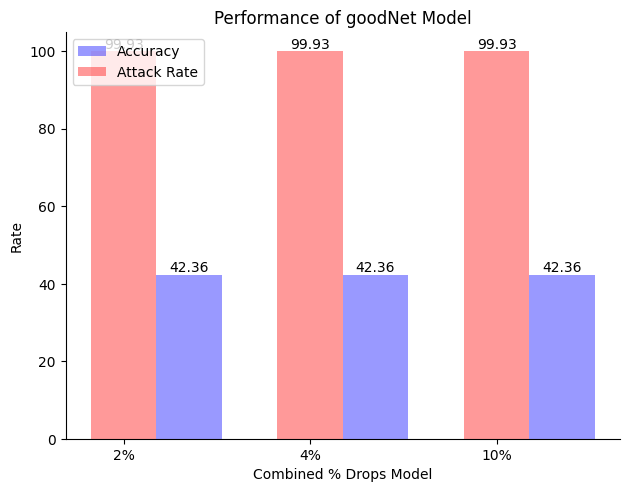

In [28]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('Combined % Drops Model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)), ('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='Accuracy')
bar2 = plt.bar(np.arange(len(G_attack_rate)), G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='Attack Rate')

for bars in [bar1, bar2]:
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Performance of goodNet Model')
sns.despine()
plt.show()
